In [1]:
# Window
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>.output_result { width:90% !important; }</style>"))

# Study of Nonlocal Misfit Scalar Regularization Parameter $\lambda$ System

<div class="alert alert-block alert-danger">
These notebooks are better visualized using codefolding from Jupyter 
    <a href="https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/">extensions</a>.
</div>

In [2]:
# Packages
import numpy as np
import pandas as pd
import scipy.sparse as sparse

import numba
from   numba import jit

import time
import itertools

#import imageio
#from   skimage.transform import resize
from   skimage.metrics   import structural_similarity as ssim
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
from   matplotlib    import ticker
from matplotlib.gridspec import GridSpec

import skimage.io    as io
import skimage.color as color
from   skimage              import data_dir
from   skimage.transform    import resize
from   mpl_toolkits.mplot3d import Axes3D
from   matplotlib           import cm
from   matplotlib.ticker    import LinearLocator, FormatStrFormatter, MultipleLocator

<div class="alert alert-block alert-success">
We study the following scalar nonlocal bilevel problem:
\begin{align*}
        &\min \dfrac{1}{2} \|u-u^T\|^2_{0,\Omega} =: f(\lambda)
    \\
    \text{subject to}\qquad
    \\
        & (u,\phi)_V + \big( \lambda(u-f), \phi \big) = 0, &\forall \phi \in V.
\end{align*}
</div>

$\DeclareMathOperator{\AK}{\mathrm{AK}_\sigma}$
The nonlocal product $(u,\phi)_V$ is defined as
\begin{align}
    (u,\phi)_V = ( u \AK \mathbb{1} - \AK u, \phi )_{L^2(\Omega)}.
\end{align}
Here $\AK$ represents the unnormalised _extended Gaussian ANOVA kernel_, which in turn is given by:
\begin{align}
    \AK u (x) = \sum_{\ell=1}^L \frac{1}{L} \int_\Omega u(y)\, e^{-\sigma^{-2} \big\| \mathcal{W}_\ell [f](x) - \mathcal{W}_\ell [f](y) \big\|^2}  \mathrm{d}y,
\end{align}
where $\sigma$ is a shape parameter, $L$ is the number of kernels to combine, and $\mathcal{W}_\ell = \{ w_1^\ell, w_2^\ell, w_3^\ell \} \in \{ 1, \dots, d \}^3$ are patches of features, so that $\mathcal{W}_\ell [f](x)$ and $\mathcal{W}_\ell [f](y)$ are the data points restricted to the corresponding features. 
The normalised version of this kernel is given by the quotient $\AK u / \AK \mathbb{1}$. In this notebook we will explore the use of the nonequispaced spherical transform to compute $\AK u$ and its use for image denoising tasks.
We have a weighted sum of multiple kernels, where every kernel relies on not more than 3 features and, thus, we can apply the NFFT-based fast summation approach and use the [`fastadj`](https://github.com/dominikalfke/FastAdjacency) package by Dominik Alfke to speed up the kernel-vector multiplication.

The nonequispaced Gauss transform computes, for a given $d$-dimensional *point cloud* of $n$ points $x_i \in \mathbb{R}^d$, $i=1,\ldots,n$, the action of the operator
\begin{align}
A = (a_{ij})_{i,j=1}^n \in \mathbb{R}^{n \times n}, \qquad A_{ij} = \exp\left(\frac{-\|x_i - x_j\|^2}{\sigma^2}\right).
\end{align}

We will apply the extended Gaussian ANOVA toolkit [`nfft4anova`](https://github.com/wagnertheresa/NFFT4ANOVA) by Theresa Wagner to determine $L$ and the feature patches $\mathcal{W}_\ell [f]$.

In [3]:
import fastadj

In [4]:
# Local packages
from sys import path
path.insert(0, 'NFFT4ANOVA/nfft4anova')
from nfft_kernel_ridge import NFFTKernelRidge        # extended Gaussian ANOVA computation toolbox

In [5]:
# Aliases
from scipy.sparse.linalg import LinearOperator, minres
from scipy.sparse        import csr_matrix
from scipy.optimize      import Bounds, minimize
from scipy.stats         import describe
from pandas              import DataFrame

# Numpy aliases
from numpy import linspace, pad, broadcast_to
from numpy.lib.stride_tricks import sliding_window_view

from numpy        import asarray, logspace, sqrt, clip, around, array, square, ravel, empty, meshgrid
from numpy        import multiply, add, reciprocal, subtract, empty_like, stack, arange
from numpy        import zeros, append, diagflat, triu, tril, logical_and, where, ones, minimum, allclose
from numpy.linalg import inv, norm
from numpy.random import default_rng
lsolver     = sparse.linalg.lgmres

In [6]:
# More alisases
from sklearn.metrics.pairwise import rbf_kernel
from skimage                  import data
from skimage.transform        import rescale
from imageio                  import imwrite, imread

from IPython.display          import Latex

from scipy.sparse.linalg      import eigsh, eigs
from scipy.linalg             import eigvals, eigvalsh, svdvals
from scipy.spatial.distance   import cdist
from scipy.optimize           import curve_fit
from numpy.lib.stride_tricks  import as_strided

<div class="alert alert-block alert-info">
We load one image from the data set.
</div>

In [7]:
images = { 1:'lena',  2:'baboon', 3:'fprint3', 4:'cameraman', 5:'monarch', 
           6:'sails', 7:'fruits', 8:'peppers', 9:'mountain', 10:'texmos3',
          11:'zebra'}

In [8]:
nume = 5                       # Selected image

Once an image is selected, a new sub-data set is created with **five** new noisy images stored in list `noisy`.

In [9]:
image = data.cell()

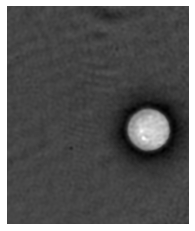

In [10]:
plt.imshow(image, cmap='gray');    plt.axis('off');    plt.show()

In [11]:
image = 255*rescale(image, 0.1, anti_aliasing=True)

We will use a specific image size that is tractable and collect set-up time and operator time:

In [12]:
Scales = np.logspace(-2,0.0,10)

Setup matrices and operators (set $\mathrm{diag}(\Gamma) = 0$):

In [13]:
# Scale image
img = rescale(image, 1.0, anti_aliasing=True)
img = asarray(img).astype(float, copy = False)
N,M = img.shape
nm  = img.size
print(N,M,nm)

# Create noisy sample
## Fix seed
rng = default_rng(10)
σ_i = logspace(1,3,5)[3]
f = rng.normal(0, sqrt(σ_i), img.shape);    f += img;    clip(f, 0.0, 255.0, out=f)
print('{0:10} -> {1}'.format( around(σ_i,2), around(ssim(img, f, data_range=f.max()-f.min() ),2)  ))

# Patch radius
ρ = 5


'''
    Kernel Setup
'''
def SSIM(img,u, N,M):  return ssim(img, u.reshape(N,M), data_range=u.max()-u.min())


clf = NFFTKernelRidge(sigma=1.0, norm = None, setup = 'default')
ρ̂    = 2*ρ+1

"""Patches"""
Fᵖᵃᵈ = pad(f, ρ, mode='constant')
X = sliding_window_view(Fᵖᵃᵈ, (ρ̂,ρ̂)).reshape(nm, ρ̂**2)

'''Build windows'''
window_scheme = 'mis'
# determine windows of features by their mis
if window_scheme == 'mis':
    res_idx = clf.make_mi_scores(X, around(f).astype(int).ravel())
    windows = clf.get_mis_windows(res_idx)

# windows are built following the feature indices in ascending order
elif window_scheme == 'consec':
    d    = X.shape[1]
    windows = [list(range((l*3),(l*3) + 3)) for l in range(d//3)]

    # if |d| is not divisible by 3, the last window contains only 1 or 2 indices
    if d%3 != 0:    windows.append( [l for l in range(d - d%3, d)] )

# use predefined list of windows of features
elif window_scheme == None:
    windows = pre_list

num_windows = len(windows)

'''Weights'''
# Select weight creation mode
weight_scheme = 'equally weighted'

# Compute kernel weights: equal weights that sup up to 1 or no weighting:
k_weight = 1.0/num_windows if weight_scheme == 'equally weighted' else 1.0

# Store weights efficiently as a view
weights = broadcast_to(k_weight, (num_windows, ))


'''Kernel as abstract object'''
def W(σ, n = 64, m = 8, p = 8, Other_Setup = None):
    '''
    Set up the subkernel matrices that constitute the extended Gaussian ANOVA kernel

    Note
    ----
    Using the NFFT-approach, the kernel matrices are never computed explicitly.

    Parameters
    ----------
    X : ndarray
        The training data matrix.
    σ : float
        Shape of the kernel.
    n : even int
        The NFFT expansion degree.
    m : int ≤ max(N,M)
        Window cutoff.
    p : int
        Smoothness of the window function.

    Returns
    -------
    SubKernels : list of fastadj.AdjacencyMatrix
        Subkernel matrices for each window of features according to the selected window scheme.
    '''

    # Bound on window cutoff [Lemma 3.4]
    if n < max([4*m,12]):
        print('Changing n = {} to {}'.format(n, max([4*m,12])))
        n = max([4*m,12])

    # Setup approximation parameters
    NFFT_setup = fastadj.AccuracySetup(n,m,p,0,0)   if Other_Setup is None else   Other_Setup

    # Set diagonal → 1, since FastAdjacency package is targeted at graph Laplacian with zeros at the diagonal
    # but we need 1 at the diagonal
    return [fastadj.AdjacencyMatrix(X[:,windows[l]], σ, NFFT_setup, 0.0) for l in range(num_windows)]
σ = 30.0


SubKernels = W(σ, Other_Setup = 'default')


def AK(u):
    """
    Approximate the matrix-vector product AK*u, where AK = w_1*K_1 + w_2*K_2 + ... + w_L*K_L.

    Note
    ----
    Since this function serves a LinearOperator from scipy, only one variable can be passed as input parameter.
    Any other variable needed has to be global, so that they can still be used within this function

    Parameters
    ----------
    u : ndarray
        The vector, whose product AK*u with the matrix AK shall be approximated.

    Returns
    -------
    AKu : ndarray
        The approximated matrix-vector product AK*u.
    """

    # Apply matrix-vector multiplication
    subKernelProducts = asarray([SubKernels[l].apply(u) for l in range(num_windows)])

    # Multiply each subKernel by its weight and collect into a sum
    AKu = weights.dot(subKernelProducts)

    return AKu

Kernel = LinearOperator(shape = (nm,nm), matvec = (AK), rmatvec = (AK))


'''Kernel as an explicit object'''
def Full_W(σ):
    B = np.zeros([nm,nm])
    for l in range(num_windows):
        B += rbf_kernel(X[:,windows[l]], gamma = (σ**-2) )
    B *= k_weight
    return B

if nm < 8670:
    ANOVA = Full_W(σ)

# Define rhs
u = f.ravel()/nm

66 55 3630
    316.23 -> 0.29


---

In [14]:
# Set weight
μ = 2e-2

In [15]:
λ = 1e-9

# Unitary transformation

In [16]:
U = np.triu(ones([nm,nm]), 1)
U[:,0] = 1.0
U -= np.diag([0.0] + list(np.arange(1,nm)) ) 
#np.dot(U, np.diag( [ np.sqrt(1/nm) ] + list( sqrt( 1.0 / (np.arange(2,nm+1) * np.arange(1,nm))) ) ), out = U )
U *= ( 1.0 / np.sqrt([nm] + list(np.arange(2,nm+1) * np.arange(1,nm))) )

---

# Eigenvalues of $A$ for different $\sigma$

## Tests in the regime $\sigma < 10$

In [17]:
from sklearn.metrics.pairwise import euclidean_distances

Under this regime, a precision issue results in the exponential of very large negative numbers being reported as $1$ instead of $0$. This occurs whenever the argument of the exponential is below the smallest normal number under IEEE.

```Python
(euclidean_distances(X[:,windows[2]] * ((1e-7)**-2)) > -np.log(np.finfo(np.float).tiny)).any()
>> True
```

To overcome this, we will modify the function `Full_W` and replace `rbf_kernel` with a careful check of the values at hand. Values that are below the precision threshold will be automatically set to zero.

In [18]:
def Full_W(σ, L=range(num_windows), printing = False):
    B = np.zeros([nm,nm])
    for l in L:
        D       = euclidean_distances(X[:,windows[l]])
        Checker = (D >= -np.log(np.finfo(np.float).tiny) * (σ**2))
        if printing:
            print(l, nm*nm - Checker.sum() - nm) # Also remove diagonal
        Pre_B   = np.exp(-D * (σ**-2))
        Pre_B[Checker] = 0.0           # These values are below machine precision

        B += Pre_B
    B *= k_weight
    return B

Before we test it in the dataset, let us explore what happens on some subkernels:

In [19]:
# A nonlocal component is totally connected, here all values get pulled down to λ:
ANOVA = np.exp(-euclidean_distances(X[:,windows[1]]) * ((0.01)**-2));    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )

In [20]:
Σ_a = np.linalg.eigvalsh( μ*np.diag(η) + np.diag(nm*[λ]) - μ*ANOVA )
Σ_a

array([1.e-09, 1.e-09, 1.e-09, ..., 1.e-09, 1.e-09, 1.e-09])

In [21]:
describe(η)

DescribeResult(nobs=3630, minmax=(0.0, 2.2219479086232803e-128), mean=1.2242137237593831e-131, variance=2.719389567105073e-259, skewness=nan, kurtosis=nan)

For a smaller value of $\sigma$, some nodes are disconnected:

In [22]:
# A nonlocal component is totally connected, here all values get pulled down to λ:
ANOVA = np.exp(-euclidean_distances(X[:,windows[1]]) * ((0.1)**-2));    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )

In [23]:
Σ_a = np.linalg.eigvalsh( μ*np.diag(η) + np.diag(nm*[λ]) - μ*ANOVA )
Σ_a

array([1.00000000e-09, 1.00000000e-09, 1.00000000e-09, ...,
       4.37827216e-06, 8.34109290e-06, 2.11605784e-03])

In [24]:
print(Σ_a[Σ_a> 2e-9])

[6.98767227e-09 1.05104561e-08 2.02815233e-08 3.64901261e-08
 9.12474673e-07 4.37827216e-06 8.34109290e-06 2.11605784e-03]


In [25]:
nm - np.count_nonzero(η) # Number of isolated nodes

332

Identify connected components:

In [26]:
from scipy.sparse.csgraph import connected_components

In [27]:
Base = np.zeros([nm,nm])
Base[ANOVA>0] = 1.0

In [28]:
connected_components(csgraph=Base, directed=False, return_labels=False)

418

How do the eigenvalues behave?

In [29]:
ANOVA = np.exp(-euclidean_distances(X[:,windows[1]]) * ((5)**-2));    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )
np.linalg.eigvalsh( μ*np.diag(η) + np.diag(nm*[λ]) - μ*ANOVA )[-1]

50.924352067853484

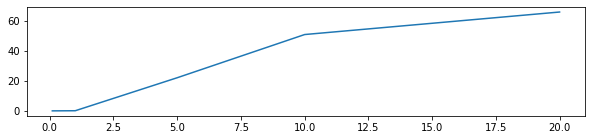

In [30]:
plt.figure(figsize=(10,2))
plt.plot([0.1, 0.5, 1, 5, 10, 20 ], [0.002116057844057093, 0.03851735966256668, 0.08451066068699044, 22.104331808011544, 50.924352067853484, 65.94538466964796]);

In [31]:
ANOVA = np.exp(-euclidean_distances(X[:,windows[1]]) * ((0.1)**-2));    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )
L = μ*np.diag(η) + np.diag(nm*[λ]) - μ*ANOVA 
np.linalg.eigvalsh( np.diag( (λ + μ*η)**-0.5 ).dot(L).dot( np.diag( (λ + μ*η)**-0.5 ) )  )[-1]

1.9999990548467002

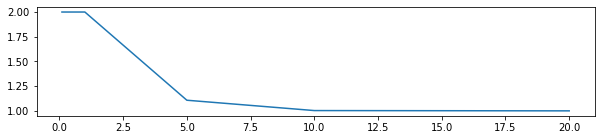

In [32]:
plt.figure(figsize=(10,2))
plt.plot([0.1, 0.5, 1, 5, 10, 20 ], [1.9999990548467002, 1.9999990609801388, 1.999958437151434, 1.1080483641735406,1.0035040344001303, 1.0005353447310092]);

In [33]:
np.linalg.eigvalsh( np.diag( (λ + μ*η)**-0.5 ).dot(L).dot( np.diag( (λ + μ*η)**-0.5 ) )  )

array([9.45153301e-07, 2.39747989e-04, 4.56696896e-04, ...,
       1.99954330e+00, 1.99976025e+00, 1.99999905e+00])

---

Now let's observe what happens when there are ones in the off-diagonal elements:

In [34]:
del ANOVA
# Setup Laplacian
ANOVA = Full_W(1e-8);    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )

In [35]:
describe(ANOVA[ANOVA>0]), nm*nm

(DescribeResult(nobs=269262, minmax=(0.024390243902439025, 0.3170731707317073), mean=0.03951759017556752, variance=0.00046024536446937517, skewness=1.406541111585835, kurtosis=3.195481484167054),
 13176900)

In [36]:
weights[0]   # The weights are the lower bounds

0.024390243902439025

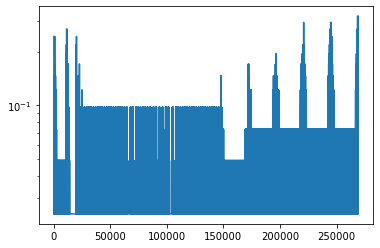

In [37]:
plt.plot(ANOVA[ANOVA>0])
plt.yscale('log')

In [38]:
describe(η)

DescribeResult(nobs=3630, minmax=(0.0, 33.43902439024393), mean=2.9312907343949477, variance=46.332719741288074, skewness=2.3583771280536614, kurtosis=4.304165270490378)

In [39]:
np.linalg.eigvalsh( μ*np.diag(η) + np.diag(nm*[0]) - μ*ANOVA )

array([-5.69706846e-16, -5.43518674e-16, -5.30127973e-16, ...,
        6.59981646e-01,  6.67955384e-01,  6.74189375e-01])

In [40]:
L = μ*np.diag(η) + np.diag(nm*[λ]) - μ*ANOVA 
np.linalg.eigvalsh( np.diag( (λ + μ*η)**-0.5 ).dot(L).dot( np.diag( (λ + μ*η)**-0.5 ) )  )[-1]

1.9999979500042024

In [41]:
np.linalg.eigvalsh( np.diag( (λ + μ*η)**-0.5 ).dot(L).dot( np.diag( (λ + μ*η)**-0.5 ) )  )

array([3.67931806e-09, 2.04999580e-06, 9.61702925e-02, ...,
       1.07202652e+00, 1.11111109e+00, 1.99999795e+00])

In [42]:
'{0:.2e}'.format(Out[477][-1]/Out[477][0])

'5.44e+08'

Now let's obseve which subkernel is not associated with a complete graph:

In [43]:
Full_W(1e-8, L=range(num_windows), printing = True);

0 0
1 0
2 20
3 0
4 6
5 14280
6 2
7 90
8 14042
9 30
10 30
11 30
12 30
13 30
14 0
15 0
16 42
17 6
18 90
19 182
20 0
21 12
22 4692
23 110
24 210
25 5700
26 240
27 90
28 30
29 240
30 75900
31 21462
32 552
33 462
34 48180
35 72092
36 462
37 56
38 462
39 420
40 175982


We can then build an ANOVA kernel out of the windows $\{0,1,3,20\}$:

In [44]:
Full_W(1e-8, L=[0,1,3,20], printing = True);

0 0
1 0
3 0
20 0


Let's redo the eigenvalue tests but only for $P_a$ and $D_a$:

In [45]:
U = np.triu(ones([nm,nm]), 1)
U[:,0] = 1.0
U -= np.diag([0.0] + list(np.arange(1,nm)) ) 
#np.dot(U, np.diag( [ np.sqrt(1/nm) ] + list( sqrt( 1.0 / (np.arange(2,nm+1) * np.arange(1,nm))) ) ), out = U )
U *= ( 1.0 / np.sqrt([nm] + list(np.arange(2,nm+1) * np.arange(1,nm))) )

In [46]:
# Pre allocate memory
Exact_Spectrums, Prec_Spectrums_P_a = np.zeros([2, 20,nm])
Prec_Spectrums_D_a = np.zeros([20,nm-1])

Σ = np.logspace(-5, 0.6, 20) * 13
k = 0
timed = 0

for σ in Σ:
    print('{0:.2e} – '.format(σ), end ='')
    # Build ANOVA base
    ANOVA = Full_W(σ, L=[0,1,3,20]);    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )
    # Transform ANOVA kernel to unitary base
    UTAU = (U.T).dot( μ * ( np.diag(η) - ANOVA ) ).dot(U)  # No need of λ here
    UTAU[0,:] = UTAU[:,0] = 0.0
    
    # Build preconditioners
    ## Diagonal precs
    diag_Pₐ = (μ * η + λ)**-1                                         # Inverse diagonal of Pₐ
    
    # Transform diagonal preconditioner into unitary basis
    U_t_Pₐ_U = U.T.dot(np.diag(diag_Pₐ)).dot(U)
    DₐAₓ = U_t_Pₐ_U.dot(UTAU + np.diag([λ]*(nm), 0))
    Lower_Rₐ_block = DₐAₓ[1:,1:].view()    # Project
    
    # Run each test
    ## P_a
    print('o, ' , end = '')
    L = μ * ( np.diag(η + λ/μ) - ANOVA )
    start = time.time()
    Exact_Spectrums[k,:] = eigvalsh( L, check_finite='false')
    end = time.time()
    timed += (end-start)
    
    ## P_a
    print('a, ' , end = '')
    L = (np.diag(diag_Pₐ**0.5).dot( μ * ( np.diag(η + λ/μ) - ANOVA ) )).dot( np.diag(diag_Pₐ**0.5) )
    start = time.time()
    Prec_Spectrums_P_a[k,:] = eigvalsh( L, check_finite='false')
    end = time.time()
    timed += (end-start)
    
    ## D_a
    print('π_a: ' , end = '')
    start = time.time()
    Prec_Spectrums_D_a[k,:] = np.sort( eigvals( Lower_Rₐ_block, check_finite='false').real )
    end = time.time()
    timed += (end-start)
    
    # Free memory for new iteration
    del ANOVA, L, U_t_Pₐ_U, DₐAₓ, Lower_Rₐ_block
    k +=1
    print('{0:.2f} '.format(timed))

1.30e-04 – o, a, π_a: 12.95 
2.56e-04 – o, a, π_a: 25.89 
5.05e-04 – o, a, π_a: 38.74 
9.96e-04 – o, a, π_a: 51.90 
1.96e-03 – o, a, π_a: 64.67 
3.87e-03 – o, a, π_a: 77.63 
7.63e-03 – o, a, π_a: 90.49 
1.50e-02 – o, a, π_a: 103.44 
2.96e-02 – o, a, π_a: 117.04 
5.84e-02 – o, a, π_a: 130.39 
1.15e-01 – o, a, π_a: 144.86 
2.27e-01 – o, a, π_a: 159.24 
4.47e-01 – o, a, π_a: 176.30 
8.82e-01 – o, a, π_a: 193.89 
1.74e+00 – o, a, π_a: 210.79 
3.43e+00 – o, a, π_a: 226.85 
6.76e+00 – o, a, π_a: 269.70 
1.33e+01 – o, a, π_a: 287.02 
2.63e+01 – o, a, π_a: 308.94 
5.18e+01 – o, a, π_a: 333.04 


In [47]:
from matplotlib.colors import to_hex, to_rgb
# Define the transformation: shift, log, and reshift
def transform(y):
    return np.sign(y - 1) * np.log1p(np.abs(y - 1))**0.5

def inverse_transform(y):
    return np.sign(y) * np.expm1(np.abs(y**2)) + 1
def colorFader(c1,c2,mix=0): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    c1 = np.array(to_rgb(c1))
    c2 = np.array(to_rgb(c2))
    return to_hex((1-mix)*c1 + mix*c2)

In [48]:
Σ

array([1.30000000e-04, 2.56259630e-04, 5.05146137e-04, 9.95758171e-04,
       1.96286631e-03, 3.86925687e-03, 7.62718719e-03, 1.50349243e-02,
       2.96372627e-02, 5.84217997e-02, 1.15162683e-01, 2.27011896e-01,
       4.47492187e-01, 8.82109095e-01, 1.73883808e+00, 3.42764617e+00,
       6.75667183e+00, 1.33189402e+01, 2.62546668e+01, 5.17539322e+01])

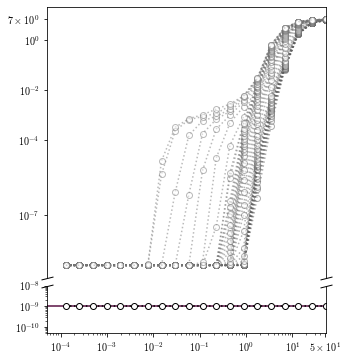

In [49]:
# A
fig = plt.figure(figsize=(5, 6))
gs = GridSpec(2, 1, height_ratios=[85, 15], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# Select indices to sample from (nm is large)
Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))
Index_Range = np.unique(np.sort(np.r_[nm - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))
#Index_Range = np.arange(1,nm, 20)

# –––––––– Plotting –––––––– #
kk=1
for k in Index_Range:
    ax[0].plot(Σ, Exact_Spectrums[:,k], linestyle=':', marker='o', alpha=0.5, 
               color = colorFader('#5A5A5A','#787878',kk/Index_Range.size), markerfacecolor = 'white' );
    kk +=1
#ax[0].axhline(y= μ * nm, color='#C14953', linestyle='--')

# The second panel contains the smallest eigenvalues
ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
ax[1].plot(Σ, λ * np.ones_like(Σ), linestyle=':', marker='o', alpha=1, color = 'black', markerfacecolor='white' );
ax[1].set_ylim(5e-11, 3e-9)
ax[1].set_xlim(5e-5, Σ[-1])
ax[0].set_xlim(5e-5, Σ[-1])
#ax[1].set_xlim(10.266995042198511, 1846.8998767182368)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#ax[0].set_yscale('function', functions=(transform, inverse_transform))
ax[0].set_yscale('log')
ax[1].set_yscale('log')


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [-4,-3,-2,-1,0,1,1]
ax_val  = [ 1,1,1,1,1,1,5]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [-7, -4, -2, 0, 0]
ax_val  = [ 1, 1, 1, 1, 7]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [-10,-9,-8]
ax_val  = [1,1,1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax and ax2
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Eigs_A_Sigma_Case_a.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

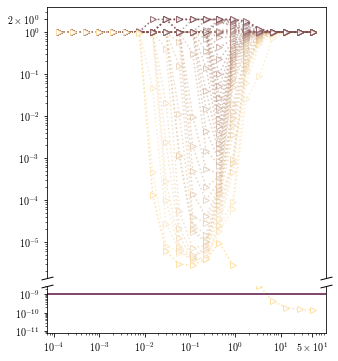

In [50]:
# P_a^-1 A
fig = plt.figure(figsize=(5, 6))
gs = GridSpec(2, 1, height_ratios=[85, 15], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

fig.subplots_adjust(hspace=0.05)  # adjust space between axes

# Select indices to sample from (nm is large)
Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))
Index_Range = np.unique(np.sort(np.r_[nm - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))
#Index_Range = np.arange(1,nm, 20)

# –––––––– Plotting –––––––– #
kk=1
for k in Index_Range:
    ax[0].plot(Σ, np.nan_to_num(Prec_Spectrums_P_a[:,k], copy=True, nan=2.0), linestyle=':', marker='>', alpha=0.5, 
               color = colorFader('#ffe1a8','#723d46',kk/Index_Range.size), markerfacecolor='white' );
    kk +=1

# The second panel contains the smallest eigenvalues
ax[0].plot(Σ[:14], Prec_Spectrums_P_a[:,0][:14], linestyle=':', marker='>', alpha=1, color = colorFader('#ffe1a8','#723d46',0), markerfacecolor='white' );
ax[1].plot(Σ, Prec_Spectrums_P_a[:,0], linestyle=':', marker='>', alpha=1, color = colorFader('#ffe1a8','#723d46',0), markerfacecolor='white' );
ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
ax[1].set_ylim(8e-12, 3e-9)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#ax[0].set_yscale('function', functions=(transform, inverse_transform))
ax[0].set_yscale('log')
ax[1].set_yscale('log')


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [-4,-3,-2,-1,0,1,1]
ax_val  = [ 1,1,1,1,1,1,5]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [-7, -5, -4, -3, -2, -1, 0, 0]
ax_val  = [ 1, 1, 1, 1, 1, 1, 1, 2]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [-11,-10,-9]
ax_val  = [1,1,1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax and ax2
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Eigs_M_Diag_a_Sigma_Case_a.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

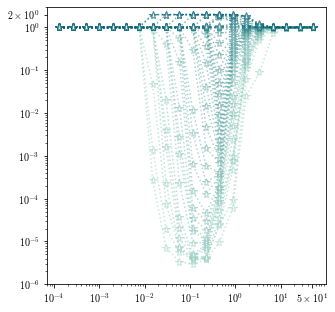

In [51]:
# π[D_a^-1 A]
fig, ax = plt.subplots(1,1, facecolor='w', figsize=(5,6*0.85))

Base_Range  = np.unique(np.logspace(0,np.log10(nm), 40).astype(int))[:-1]
Index_Range = np.unique(np.sort(np.r_[(nm-1) - np.unique(np.logspace(0,np.log10(nm), 10).astype(int)), Base_Range]))

# –––––––– Plotting –––––––– #
kk=1
for k in Index_Range:
    plt.plot(Σ, Prec_Spectrums_D_a[:,k], linestyle=':', marker='*', alpha=0.5, markersize=8, 
             color = colorFader('#94d2bd','#005f73',kk/Index_Range.size), markerfacecolor='white' );
    kk +=1

    
# Set scales
ax.set_xscale('log')
#ax.set_yscale('function', functions=(transform, inverse_transform))
ax.set_yscale('log')
ax.set_ylim(0.4, 3)

# –––––––– Ticks –––––––– #
# Add more ticks in x-axis
ax_base = [-4,-3,-2,-1,0,1,1]
ax_val  = [ 1,1,1,1,1,1,5]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_xticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — First panel
ax_base = [-6, -5, -4, -3, -2, -1, 0, 0]
ax_val  = [ 1, 1, 1, 1, 1, 1, 1, 2]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax.set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# –––––––– Store –––––––– #
fig.savefig('Eigs_M_Proj_a_Sigma_Case_a.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

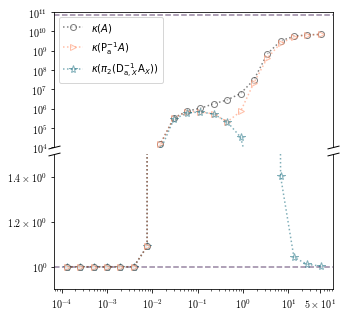

In [52]:
# κ
fig = plt.figure(figsize=(5, 6*0.85))
gs = GridSpec(2, 1, height_ratios=[50, 50], hspace=0.05, figure=fig)

# Create two axes
ax = fig.add_subplot(gs[0]), fig.add_subplot(gs[1])

# –––––––– Plotting –––––––– #
# First panel
ax[0].axhline(y= 1+μ*nm/λ, color='#9684A1', linestyle='--')
ax[0].plot(Σ, Exact_Spectrums[:,-1] / λ, linestyle=':', marker='o', alpha=0.5, 
           color = 'black', markerfacecolor='white', label='$\kappa(A)$')
ax[0].plot(Σ, np.nan_to_num(Prec_Spectrums_P_a[:,-1], copy=True, nan=2.0) / Prec_Spectrums_P_a[:,0], linestyle=':', marker='>', alpha=0.5, 
           color='#FF7F50', markerfacecolor='white', label='$\kappa(\mathsf{P}_{\mathsf{a}}^{-1}A)$')
ax[0].plot(Σ, Prec_Spectrums_D_a[:,-1] / Prec_Spectrums_D_a[:,0], linestyle=':', marker='*', alpha=0.5, markersize=8, 
            color='#005f73', markerfacecolor='white', label='$\kappa( \pi_2 ( \mathsf{D}_{\mathsf{a},X}^{-1} \, \mathsf{A}_{X}) )$')
    
## Present legend
ax[0].legend(loc='upper left', ncols = 1)


# Second panel
ax[1].axhline(y= 1.0, color='#9684A1', linestyle='--')
ax[1].plot(Σ, Prec_Spectrums_D_a[:,-1] / Prec_Spectrums_D_a[:,0], linestyle=':', marker='*', alpha=0.5, markersize=8, 
            color='#005f73', markerfacecolor='white', label='$\kappa( \pi_2 ( \mathsf{D}_{\mathsf{a},X}^{-1} \, \mathsf{A}_{X}) )$')
ax[1].plot(Σ, Exact_Spectrums[:,-1] / λ, linestyle=':', marker='o', alpha=0.5, 
           color = 'black', markerfacecolor='white', label='$\kappa(A)$')
ax[1].plot(Σ, np.nan_to_num(Prec_Spectrums_P_a[:,-1], copy=True, nan=2.0) / Prec_Spectrums_P_a[:,0], linestyle=':', marker='>', alpha=0.5, 
           color='#FF7F50', markerfacecolor='white', label='$\kappa(\mathsf{P}_{\mathsf{a}}^{-1}A)$')

## Present legend
#ax[1].legend(loc='upper left', ncols = 1)

# The second panel contains the smallest eigenvalues
#ax[1].plot(Σ, Prec_Spectrums_P_c[:,0], linestyle=':', marker='>', alpha=1, color = colorFader('#ffe1a8','#723d46',0), markerfacecolor='white' );
#ax[1].axhline(y = λ, color='xkcd:plum', linestyle='-')        # Add line at λ
ax[0].set_ylim(1e+4, 8e+10)
ax[1].set_ylim(0.9, 1.5)

# Set scales
ax[0].set_xscale('log')
ax[1].set_xscale('log')
#ax[0].set_yscale('function', functions=(transform, inverse_transform))
ax[0].set_yscale('log')
#ax[1].set_yscale('log')
#ax[1].set_yscale('function', functions=(transform, inverse_transform))


# –––––––– Ticks –––––––– #
# Add more ticks in x-axis — Second panel
ax_base = [-4,-3,-2,-1,0,1,1]
ax_val  = [ 1,1,1,1,1,1,5]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_xticks(ax_loc, ax_lbl, fontname='CMR10')

# Add more ticks in y-axis — First panel
ax_base = [4,5,6,7,8,9,10,11]
ax_val  = [1,1,1,1,1,1,1,1]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[0].set_yticks(ax_loc, ax_lbl, fontname='CMR10');

# Add more ticks in y-axis — Second panel
ax_base = [0,0,0]
ax_val  = [1,1.2,1.4]
ax_loc  = ax_val * 10.0**asarray(ax_base)
ax_lbl  = [plt.Text(a[0], 0, '$\\mathdefault{10^{' + '{0}'.format(a[1]) + '}}$' )  if a[2] == 1 else 
           plt.Text(a[0], 0, '$\\mathdefault{' + '{}'.format(a[2]) +' \\times 10^{'+'{0}'.format(a[1]) +'}}$' )  
           for a in zip(ax_loc, ax_base, ax_val) ]
ax[1].set_yticks(ax_loc, ax_lbl, fontname='CMR10');


# –––––––– Decorators –––––––– #
# hide the spines between ax[0] and ax[1]
ax[0].tick_params(axis="x", which="both", length=0)
ax[0].xaxis.set_ticks([])
ax[0].spines['bottom'].set_visible(False)
ax[1].spines.top.set_visible(False)
ax[1].xaxis.tick_bottom()

# hide the spines between ax[0] and ax[1]
#ax[0].tick_params(labelleft=False, left=False)
#ax[1].tick_params(labelleft=False, left=False)

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax[0].plot([0, 1], [0, 0], transform=ax[0].transAxes, **kwargs)
ax[1].plot([0, 1], [1, 1], transform=ax[1].transAxes, **kwargs)

# –––––––– Store –––––––– #
fig.savefig('Condition_Sigma_b_Case_a.pdf', bbox_inches='tight', pad_inches=0)

plt.show()

# Tests on the eigenvalues of one Gaussian kernel:

In [123]:
ANOVA = (Full_W(35, L=[2], printing = False)/k_weight)/1.0;    np.fill_diagonal(ANOVA, 0.0);    η = ANOVA.dot( ones(nm) )

In [124]:
#np.fill_diagonal(ANOVA, 1.0);

In [125]:
Σ_a = np.linalg.eigvalsh( ANOVA ) + 1
Σ_a

array([-1.64313008e-14,  6.10622664e-15,  1.07691633e-14, ...,
        2.46502712e+01,  3.50554868e+01,  3.45211158e+03])

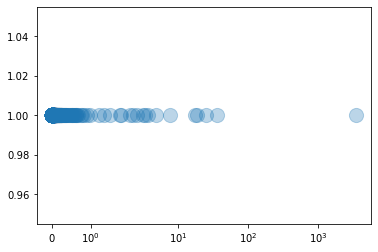

In [166]:
plt.scatter(Σ_a, nm*[1], s=200, marker='o', alpha = 0.3)
plt.xscale('symlog')

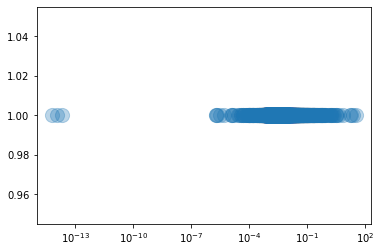

In [165]:
plt.scatter(Σ_a[:-1], (nm-1)*[1], s=200, marker='o', alpha = 0.3)
plt.xscale('log')

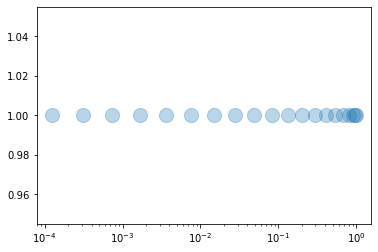

In [174]:
plt.scatter(np.exp(-np.linspace(0,3,20)**2), 20*[1], s=200, marker='o', alpha = 0.3)
plt.xscale('log')

But for small samples, it may look like it is exponential. To see this, we will sample features from smaller dimensions up to the full dimension. The first row depics the eigenvalues, while the second row is a scree plot with vertical log scale:

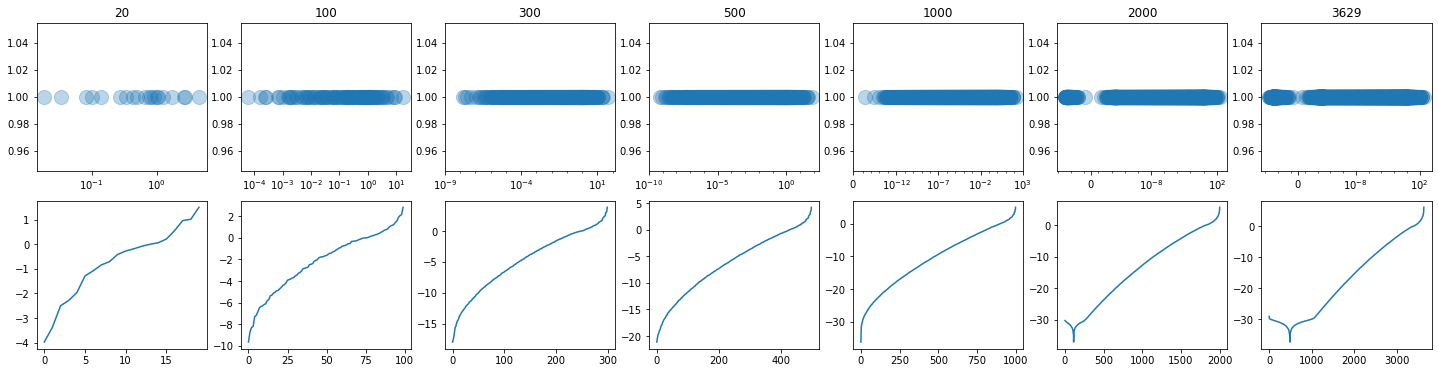

In [299]:
est = []
fig, ax = plt.subplots(2,7, facecolor='w', figsize=(25,6))
for k, i in enumerate([20, 100,300,500, 1000, 2000, 3630-1]):
    Σ_a = np.linalg.eigvalsh( np.exp( -euclidean_distances(X[:i,windows[1]]/20)**2 ) )
    est.append(Σ_a.max()/Σ_a.size)

    ax[0,k].scatter(Σ_a, Σ_a.size*[1], s=200, marker='o', alpha = 0.3)
    ax[0,k].set_xscale('symlog', linthresh=1e-16)
    if 1 < k and k < 5:
        ax[0,k].set_xticks( ax[0,k].get_xticks()[::5] )
    if k >= 5:
        ax[0,k].set_xticks( ax[0,k].get_xticks()[9::5] )
        
    ax[0,k].set_title(Σ_a.size)
        
    
    ax[1,k].plot(np.log(abs(Σ_a)))

In [300]:
est

[0.22472404410571115,
 0.17184813298401644,
 0.15736792880803993,
 0.14022658323144885,
 0.1485946586283423,
 0.13915597904024452,
 0.1304915004426138]

Clearly it does not happen in the Laplacian at all:

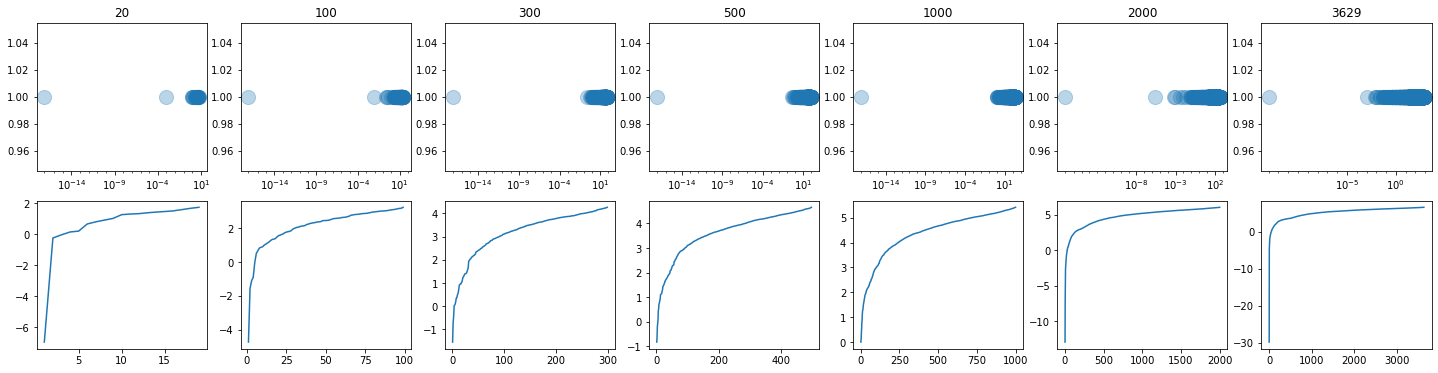

In [295]:
fig, ax = plt.subplots(2,7, facecolor='w', figsize=(25,6))
for k, i in enumerate([20, 100,300,500, 1000, 2000, 3630-1]):
    L = np.exp( -euclidean_distances(X[:i,windows[1]]/20)**2 );    np.fill_diagonal(L, 0.0);    η = L.sum(0)
    Σ_a = np.linalg.eigvalsh( np.diag(η) - L )
    np.clip(Σ_a,0, np.inf, out = Σ_a)

    ax[0,k].scatter(Σ_a, Σ_a.size*[1], s=200, marker='o', alpha = 0.3)
    ax[0,k].set_xscale('symlog', linthresh=1e-16)
    if 0 <= k and k < 5:
        ax[0,k].set_xticks( ax[0,k].get_xticks()[3::5] )
    if k >= 5:
        ax[0,k].set_xticks( ax[0,k].get_xticks()[9::5] )
        
    ax[0,k].set_title(Σ_a.size)
    
    ax[1,k].plot(np.log(abs(Σ_a)))

Not even the preconditioned version:

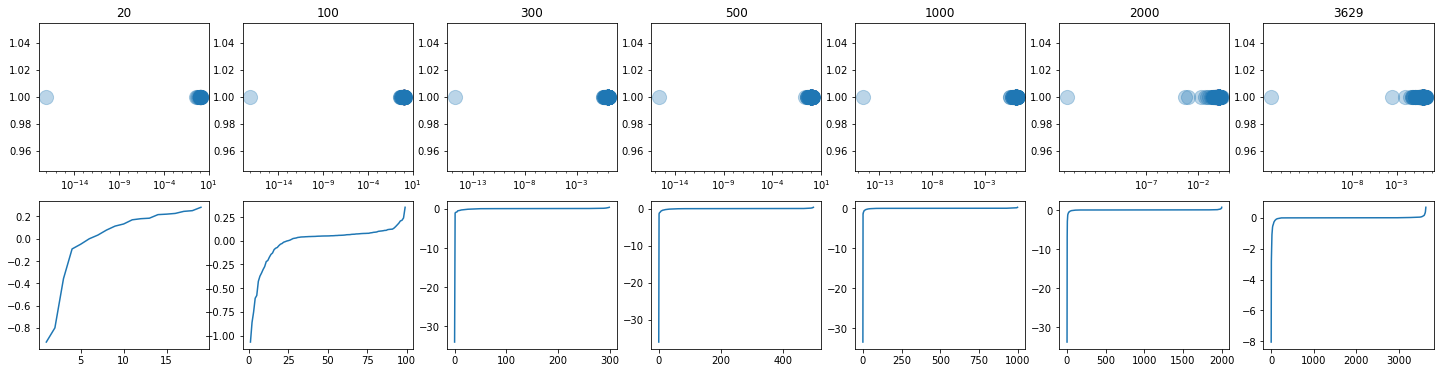

In [298]:
fig, ax = plt.subplots(2,7, facecolor='w', figsize=(25,6))
for k, i in enumerate([20, 100,300,500, 1000, 2000, 3630-1]):
    L = np.exp( -euclidean_distances(X[:i,windows[1]]/20)**2 );    np.fill_diagonal(L, 0.0);    η = L.sum(0)
    Σ_a = np.linalg.eigvalsh( np.eye(η.size) - np.diag(η**-0.5).dot(L).dot(np.diag(η**-0.5)) )
    np.clip(Σ_a,0, np.inf, out = Σ_a)

    ax[0,k].scatter(Σ_a, Σ_a.size*[1], s=200, marker='o', alpha = 0.3)
    ax[0,k].set_xscale('symlog', linthresh=1e-16)
    if 0 <= k and k < 5:
        ax[0,k].set_xticks( ax[0,k].get_xticks()[3::5] )
    if k >= 5:
        ax[0,k].set_xticks( ax[0,k].get_xticks()[9::5] )
        
    ax[0,k].set_title(Σ_a.size)
    
    ax[1,k].plot(np.log(abs(Σ_a)))

---